In [1]:
import torch
import joblib
import numpy as np
from torch import nn
import torch.optim as optim
from pathlib import Path
from data.data_loader import DroneGraphDataset
from models.pretrained_model_loader import load_pretrained_traj_model, extract_context_embeddings
from models.tgn import DroneRelationModel

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = DroneGraphDataset(
    trajectory_csv='data/drone_states.csv',
    relationship_csv='data/drone_relations.csv',
    lookback=50,
    device=device,
)

sample = dataset[0]
print(sample['context_window'].shape)    # [50, num_drones, 4]
print(sample['current_features'].shape)  # [num_drones, 4]
print(sample['relationships'].shape)     # [num_pairs, 2]
print(sample['labels'].shape)            # [num_pairs]


[Skipping] Flight 0, timestep 28.833 has 1 drones
[Skipping] Flight 1, timestep 31.3 has 1 drones
[Skipping] Flight 2, timestep 29.367 has 3 drones
[Skipping] Flight 3, timestep 32.967 has 3 drones
[Skipping] Flight 4, timestep 29.8 has 2 drones
[Skipping] Flight 5, timestep 36.567 has 2 drones
[Skipping] Flight 6, timestep 30.667 has 2 drones
[Skipping] Flight 7, timestep 27.733 has 5 drones
[Skipping] Flight 8, timestep 31.733 has 2 drones
[Skipping] Flight 9, timestep 33.667 has 5 drones
[Skipping] Flight 10, timestep 27.5 has 5 drones
[Skipping] Flight 11, timestep 36.467 has 4 drones
[Skipping] Flight 14, timestep 29.433 has 1 drones
[Skipping] Flight 15, timestep 28.833 has 2 drones
[Skipping] Flight 16, timestep 26.433 has 5 drones
[Skipping] Flight 17, timestep 33.467 has 2 drones
[Skipping] Flight 18, timestep 36.567 has 1 drones
[Skipping] Flight 19, timestep 30.2 has 3 drones
[Skipping] Flight 20, timestep 29.067 has 4 drones
[Skipping] Flight 21, timestep 38.433 has 2 drone

In [3]:
# Example usage
experiment_dir = Path("experiments/20251015_134311")

# Load model + config
model, config = load_pretrained_traj_model(experiment_dir, device)

# Load scalers
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Dummy trajectory data (replace with your actual drone trajectory segment)
dummy_data = np.random.rand(100, 6 * 3).astype(np.float32)  # 100 timesteps, 6 drones, xyz

# Extract embeddings
context_emb = extract_context_embeddings(
    model,
    traj_data=dummy_data,
    scaler_X=scaler_X,
    lookback=config["LOOK_BACK"],
    features_per_agent=3,
    device=device,
)

print("Context embeddings shape:", context_emb.shape)

Context embeddings shape: torch.Size([6, 128])


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
from torch.utils.data import Subset

flight_ids = dataset.flights
num_train = int(0.8 * len(flight_ids))
train_flights = flight_ids[:num_train]
test_flights = flight_ids[num_train:]

train_indices = [i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in train_flights]
test_indices = [i for i, (fid, _) in enumerate(dataset.valid_indices) if fid in test_flights]

train_ds = Subset(dataset, train_indices)
test_ds = Subset(dataset, test_indices)

In [5]:
def train_epoch(model, loader, optimizer, criterion, scaler_X, pretrained_model, config):
    model.train()
    total_loss = 0
    for batch in loader:
        context_window = batch["context_window"].squeeze(0).cpu().numpy()  # [50, num_drones, 4]
        current_features = batch["current_features"].squeeze(0).to('cpu')
        relationships = batch["relationships"].squeeze(0).to('cpu')
        labels = batch["labels"].squeeze(0).float().to('cpu')

        # Extract context embeddings from pretrained model
        context_emb = extract_context_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :3].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=3,
            device='cpu',
        )

        preds = model(current_features, context_emb, relationships)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

@torch.no_grad()
def evaluate(model, loader, scaler_X, pretrained_model, config, show_confusion=True):
    model.eval()
    preds_all, labels_all = [], []

    for batch in loader:
        context_window = batch["context_window"].squeeze(0).cpu().numpy()
        current_features = batch["current_features"].squeeze(0).to("cpu")
        relationships = batch["relationships"].squeeze(0).to("cpu")
        labels = batch["labels"].squeeze(0).float().to("cpu")

        context_emb = extract_context_embeddings(
            pretrained_model,
            traj_data=context_window[:, :, :3].reshape(50, -1),
            scaler_X=scaler_X,
            lookback=config["LOOK_BACK"],
            features_per_agent=3,
            device=device,
        )

        preds = model(current_features, context_emb, relationships)
        preds_all.append(preds)
        labels_all.append(labels)

    preds_all = torch.cat(preds_all)
    labels_all = torch.cat(labels_all)

    # Binary predictions
    y_true = labels_all.cpu().numpy().astype(int)
    y_pred = (preds_all.cpu().numpy() > 0.5).astype(int)

    # Compute accuracy
    acc = (y_true == y_pred).mean().item()

    if show_confusion:
        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
        disp.plot(cmap="Blues", colorbar=False)
        plt.title("Confusion Matrix")
        plt.show()

        # Optional: print precision/recall/F1
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

    return acc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


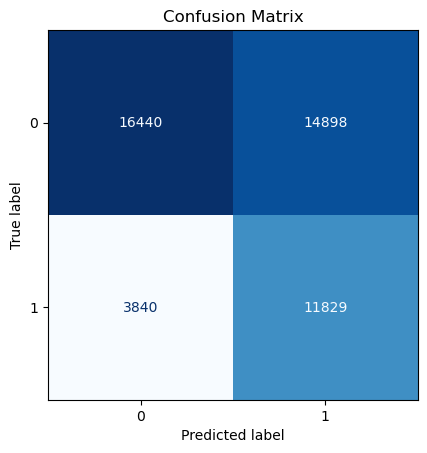

Precision: 0.443, Recall: 0.755, F1: 0.558
Epoch 1: Loss=0.2909, Test Acc=0.601


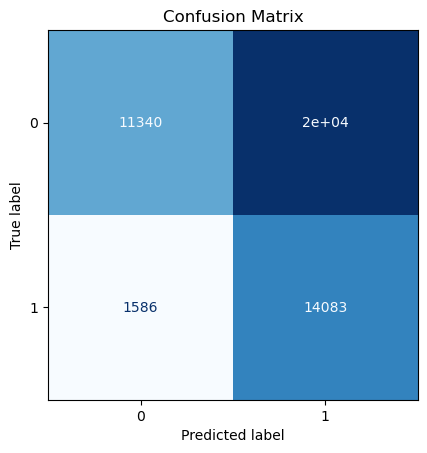

Precision: 0.413, Recall: 0.899, F1: 0.566
Epoch 2: Loss=0.2316, Test Acc=0.541


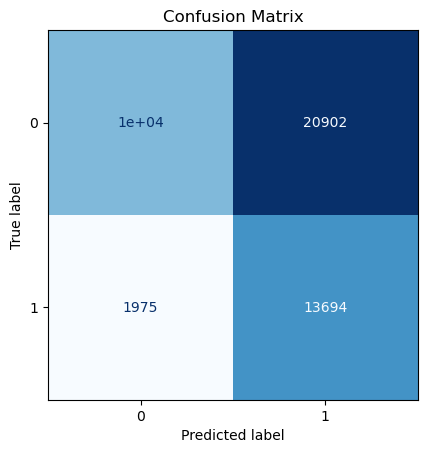

Precision: 0.396, Recall: 0.874, F1: 0.545
Epoch 3: Loss=0.2213, Test Acc=0.513


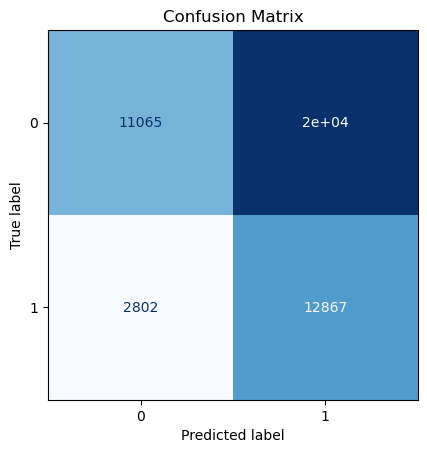

Precision: 0.388, Recall: 0.821, F1: 0.527
Epoch 4: Loss=0.2016, Test Acc=0.509


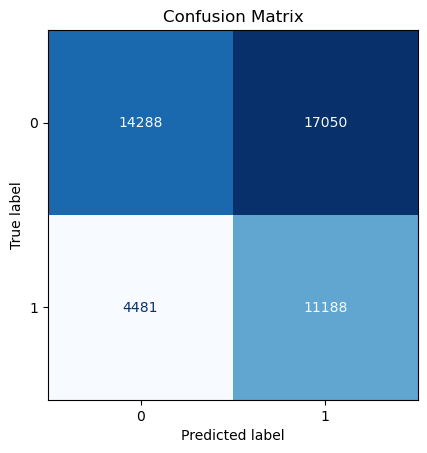

Precision: 0.396, Recall: 0.714, F1: 0.510
Epoch 5: Loss=0.2126, Test Acc=0.542


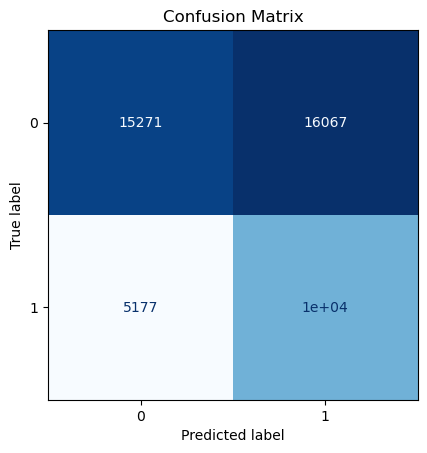

Precision: 0.395, Recall: 0.670, F1: 0.497
Epoch 6: Loss=0.2629, Test Acc=0.548


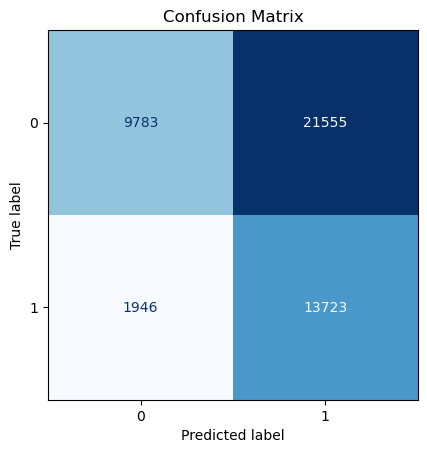

Precision: 0.389, Recall: 0.876, F1: 0.539
Epoch 7: Loss=0.5733, Test Acc=0.500


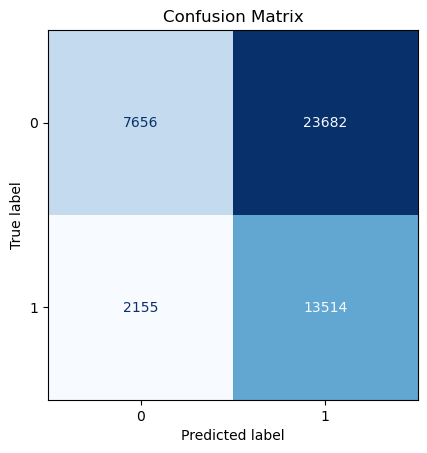

Precision: 0.363, Recall: 0.862, F1: 0.511
Epoch 8: Loss=0.1957, Test Acc=0.450


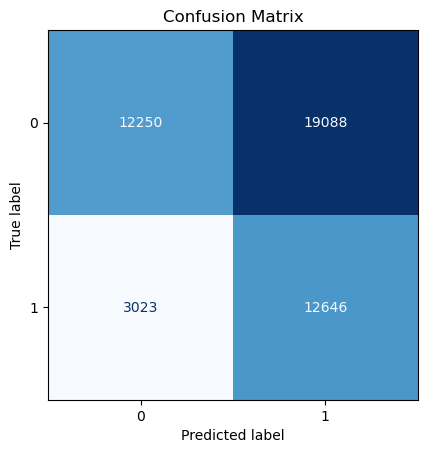

Precision: 0.399, Recall: 0.807, F1: 0.534
Epoch 9: Loss=0.3049, Test Acc=0.530


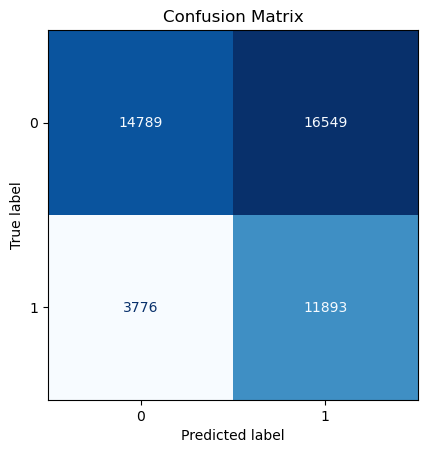

Precision: 0.418, Recall: 0.759, F1: 0.539
Epoch 10: Loss=0.2061, Test Acc=0.568


In [7]:
# Load pretrained trajectory model
model_traj, config = load_pretrained_traj_model(experiment_dir, device)
scaler_X = joblib.load(experiment_dir / "scaler_X.pkl")

# Initialize new relation model
relation_model = DroneRelationModel(context_dim=model_traj.enc_hidden_size * 2).to(device)

optimizer = optim.Adam(relation_model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

# Training loop
for epoch in range(10):
    loss = train_epoch(relation_model, train_ds, optimizer, criterion, scaler_X, model_traj, config)
    acc = evaluate(relation_model, test_ds, scaler_X, model_traj, config)
    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Test Acc={acc:.3f}")
